In [25]:
import chainer
from chainer.datasets import mnist, split_dataset_random
from chainer.dataset import concat_examples
import matplotlib.pyplot as plt
from chainer import iterators, Chain
import chainer.links as L
import chainer.functions as F
from chainer import optimizers
import numpy as np

In [35]:
train_val, test = mnist.get_mnist(withlabel=True, ndim=1)

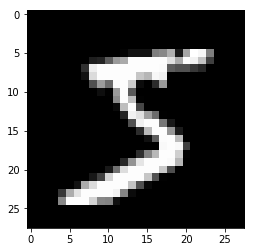

In [36]:
x, t = train_val[0]
plt.imshow(x.reshape(28, 28), cmap='gray')

In [37]:
train, valid = split_dataset_random(train_val, 50000, seed=0)

In [42]:
batchsize=128

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(
    valid, batchsize, repeat=False, shuffle=False)
test_iter = iterators.SerialIterator(
    test, batchsize, repeat=False, shuffle=False)

In [43]:
class Model(Chain):
    def __init__(self, n_mid_units=100, n_out=10):
        super(Model, self).__init__()
        
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(n_mid_units, n_mid_units)
            self.l3 = L.Linear(n_mid_units, n_out)
            
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

model = Model()

In [44]:
optimizer = optimizers.SGD(lr=0.01).setup(model)

In [45]:
max_epoch=10

while train_iter.epoch < max_epoch:
    train_batch = train_iter.next()
    x, t = concat_examples(train_batch)
    y = model(x)
    
    loss = F.softmax_cross_entropy(y, t)
    model.cleargrads()
    loss.backward()
    optimizer.update()
    
    if train_iter.is_new_epoch:
        print('epoch:{:02d} train_loss:{:.04f}'.format(
            train_iter.epoch, float(loss.data)), end=' ')
        
        valid_losses = []
        valid_accuracies = []
        
        while True:
            valid_batch = valid_iter.next()
            x_valid, t_valid = concat_examples(valid_batch)
            
            with chainer.using_config('train', False), \
                chainer.using_config('enable_backprop', False):
                    y_valid = model(x_valid)
                    
            loss_valid = F.softmax_cross_entropy(y_valid, t_valid)
            valid_losses.append(loss_valid.array)
            
            accuracy = F.accuracy(y_valid, t_valid)
            valid_accuracies.append(accuracy.array)
            
            if valid_iter.is_new_epoch:
                valid_iter.reset()
                break
        
        print('val_loss:{:.04f} vali_accuracy:{:.04f}'.format(
            np.mean(valid_losses), np.mean(valid_accuracies)))
        
test_accuracies = []
while True:
    test_batch = test_iter.next()
    x_test, t_test = concat_examples(test_batch)
    
    with chainer.using_config('train', False), \
            chainer.using_config('enable_backprop', False):
        y_test = model(x_test)

    accuracy = F.accuracy(y_test, t_test)
    test_accuracies.append(accuracy.array)
    
    if test_iter.is_new_epoch:
        test_iter.reset()
        break
        
print('test_accuracy:{:.04f}'.format(np.mean(test_accuracies)))

epoch:01 train_loss:1.0002 val_loss:0.9397 vali_accuracy:0.8076
epoch:02 train_loss:0.5349 val_loss:0.5193 vali_accuracy:0.8640
epoch:03 train_loss:0.3178 val_loss:0.4111 vali_accuracy:0.8857
epoch:04 train_loss:0.3101 val_loss:0.3631 vali_accuracy:0.8970
epoch:05 train_loss:0.3016 val_loss:0.3339 vali_accuracy:0.9032
epoch:06 train_loss:0.2848 val_loss:0.3165 vali_accuracy:0.9092
epoch:07 train_loss:0.3063 val_loss:0.3007 vali_accuracy:0.9141
epoch:08 train_loss:0.1971 val_loss:0.2879 vali_accuracy:0.9180
epoch:09 train_loss:0.3376 val_loss:0.2777 vali_accuracy:0.9210
epoch:10 train_loss:0.2457 val_loss:0.2690 vali_accuracy:0.9229
test_accuracy:0.9267
